In [18]:
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from view_test_tiles import display_video_clip


from dataset.build_dataset import threshold_image, cloud_idx, get_cloud_idx_from_image_path, get_cloud_idx_from_img

output_dir = "../airmassRGB/supervised/"

# copertura nuvolosa

In [2]:
# carica immagine AirmassRGB
image_path = "../airmassRGB/supervised/09-09-2023_2355_639_196/img_00010.png"
img = cv2.imread(image_path)  # BGR → converti in RGB se serve
if img is None:
    raise FileNotFoundError(f"Impossibile caricare l'immagine: {image_path}")

# ricava luminosità
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# trova soglia automatica
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# mask nuvole (white)
cloud_mask = thresh == 255

# percentuale di pixel nuvolosi
cloud_frac = cloud_mask.mean()

if cloud_frac > 0.05:
    print("Frame coperto da nuvole")
else:
    print("Frame sereno")


Frame coperto da nuvole


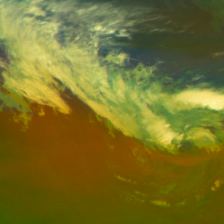

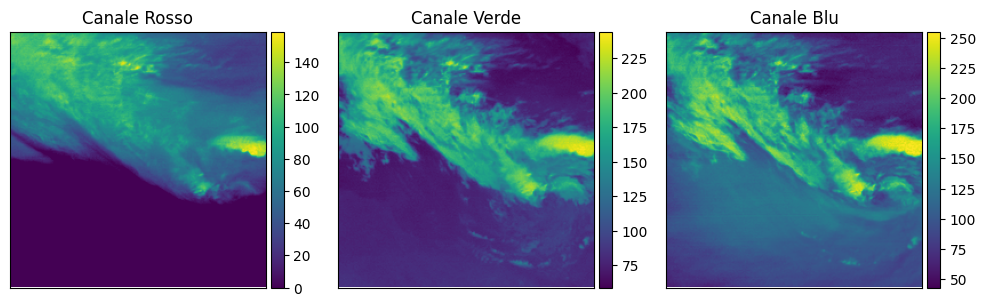

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_channel_plot(img, ax, fig, ch_name=''):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    imm = ax.imshow(img)
    fig.colorbar(imm, cax=cax, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Channel {ch_name}")


display(Image.open(image_path))

fig, axs = plt.subplots(1,3, figsize=(12, 4))
make_channel_plot(img[:,:,0], axs[0], fig, ch_name="Red")
make_channel_plot(img[:,:,1], axs[1], fig, ch_name="Green")
make_channel_plot(img[:,:,2], axs[2], fig, ch_name="Blue")


In [4]:
# calcola la soglia come percentile (es. 95° percentile)
p = 60
thresh_val = np.percentile(gray, p)

#thresh_val = 100
# genera la maschera
cloud_mask = gray > thresh_val
cloud_frac = cloud_mask.mean()

print(f"Soglia (percentile {p}): {thresh_val:.1f}")
print(f"Frazione di pixel nuvolosi: {cloud_frac*100:.2f} %")

Soglia (percentile 60): 97.0
Frazione di pixel nuvolosi: 39.89 %


Text(0.5, 1.0, 'Percentuale nuvolosa: 0.25')

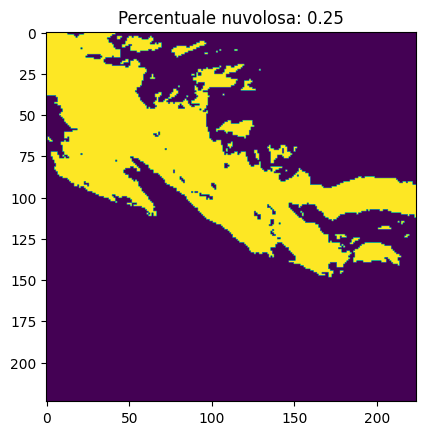

In [ ]:
cloud_mask = threshold_image(img)
plt.imshow(cloud_mask)
cl_idx = cloud_idx(cloud_mask)
plt.title(f"Percentuale nuvolosa: {cl_idx}")
plt.xticks([])
plt.yticks([])
plt.savefig("cloud_mask.png")

In [148]:
#img = cv2.imread(image_path) 
# -> apre come array

In [35]:
from arguments import prepare_finetuning_args, Args
from dataset import build_dataset
from torch.utils.data import DataLoader

args = prepare_finetuning_args()
##### prende da val_supervised.csv
dataset_val, _ = build_dataset(is_train=False, test_mode=False, args=args)  

data_loader_val = DataLoader(
    dataset_val,
    batch_size=args.batch_size,
    shuffle=True,         # Per estrarre sample casuali
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=False
)

get_prediction = False


Number of the class = 2


In [36]:
it = iter(dataset_val)

In [37]:
it.__sizeof__(), len(dataset_val)

(32, 890)

In [52]:
samples = next(it)  # samples è una tupla tipicamente (video, label, index, ...)
videos = samples[0]  # tensore di shape [B, C, T, H, W] 
labels = samples[1]  # shape [B]
folder_path = samples[2]
print(folder_path)


v0 = videos#[0]  # shape [C, T, H, W]
v0 = v0.permute(1, 2, 3, 0).cpu()  # [T, H, W, C]
#print(v0)


v0_min = v0.min()
v0_max = v0.max()
v0_vis = (v0 - v0_min) / (v0_max - v0_min + 1e-5)  # normalizzato [0,1]

masks = []
for v in v0_vis:
    im = v.numpy()
    cld_idx = get_cloud_idx_from_img(im*255)
    masks.append(threshold_image(im*255))
    #print(cld_idx)

INDICE: 10
../airmassRGB/supervised/19-02-2020_2255_852_0


In [53]:
video_display = display_video_clip(v0_vis)
display(video_display)

In [54]:
video_display = display_video_clip(masks) #v0_vis)
display(video_display)

# Calcolo copertura nuvolosa per tutto il dataset

devo aggiungere una colonna cloud idx nel master dataframe

In [3]:
from dataset.data_manager import BuildDataset

In [4]:
sup_data_train = BuildDataset(type='SUPERVISED', master_df_path="all_data_full_tiles.csv")
sup_data_train.load_master_df()

In [ ]:
#sup_data_train.master_df['cloud_idx'] = sup_data_train.master_df.iloc[:1000].path.apply(get_cloud_idx_from_image_path)

In [ ]:
sup_data_train.make_df_video(output_dir="../airmassRGB/supervised", is_to_balance=True)

In [50]:
sup_data_train.df_video.path = output_dir + sup_data_train.df_video.path

In [51]:
sup_data_train.df_video.shape

(4756, 8)

In [52]:
def calc_avg_cld_idx(video_subfolder):
    frames_cld_idx = []
    for k in range(16):
        frame_path = Path(video_subfolder) / f"img_{k+1:05d}.png"
        #display(Image.open(frame_path))
        cidx = get_cloud_idx_from_image_path(frame_path)
        #print(cidx)
        frames_cld_idx.append(cidx)
    frames_cld_idx = np.array(frames_cld_idx)

    avg = frames_cld_idx.mean()
    return avg

In [53]:
new_col_name = "avg_cloud_idx"
#for i in range(2):
#    subfolder = Path(sup_data_train.df_video.iloc[i].path)
#sub = sup_data_train.df_video.iloc[:100].copy()
sup_data_train.df_video[new_col_name] = sup_data_train.df_video.path.apply(calc_avg_cld_idx)

In [60]:
sup_data_train.df_video.path = sup_data_train.df_video.path.str.split('/').str[-1]


In [61]:
mask_cloud = sup_data_train.df_video.avg_cloud_idx > 0.2
df_video_cloudy = sup_data_train.df_video[mask_cloud]
df_video_clearsky = sup_data_train.df_video[~mask_cloud]
len(df_video_cloudy), len(df_video_clearsky)

(1219, 3537)

In [62]:
train_len = int(0.7 * len(df_video_cloudy))
#test_len = int(0.7 * len(df_video_cloudy))
cloudy_train = df_video_cloudy.sample(train_len, random_state=1)
cloudy_test = df_video_cloudy.drop(cloudy_train.index)
len(cloudy_train), len(cloudy_test)

(853, 351)

In [63]:
from dataset.build_dataset import create_final_df_csv



df_dataset_csv_cloudy_train = create_final_df_csv(cloudy_train, output_dir)
df_dataset_csv_cloudy_train.to_csv("cloudy_train_853.csv", index=False)

df_dataset_csv_cloudy_test = create_final_df_csv(cloudy_test, output_dir)
df_dataset_csv_cloudy_test.to_csv("cloudy_test_351.csv", index=False)